### Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -U colabcode
import colabcode
colabcode.ColabCode(
    port=12000,
    authtoken='21eNVw6XbU2fjExgUWxa47wNx8x_6AfyfxMFYUmSWFLxW7b72',
    lab=True
)

In [42]:
!gdown --id 1A-59GMNuJWbrbCc17zvBPkOycSdCBdCA

Downloading...
From: https://drive.google.com/uc?id=1A-59GMNuJWbrbCc17zvBPkOycSdCBdCA
To: /content/vacancies_lemmatized.csv
100% 902M/902M [00:13<00:00, 67.4MB/s] 


In [162]:
import pandas as pd
df = pd.read_csv('vacancies_lemmatized.csv')
df = df[df['language'] == 'ru']

### Лемматизация

In [ ]:
!gdown --id 1YsX2nb2IxiKICa7S1b5LLMNC0puVwwry

In [ ]:
df = pd.read_csv('vacancies_processed.csv')

In [ ]:
# !pip install pymorphy2
import pymorphy2
import re
morph = pymorphy2.MorphAnalyzer()
def lemmatize(text):
  """
  Создаём метод, который лемматизирует текст.
  Аргумент:
  text - текст, который нужно лемматизировать
  Возвращает:
  res - лемматизированный текст
  """
  try:
      words = re.split(r'\W+', text) # разбиваем текст на слова
  except:
    return text
  res = str()
  for word in words:
      p = morph.parse(word)[0]
      res += (p.normal_form) + ' '
  return res

In [ ]:
columns_for_lem = ['raw_description', 'description', 'description_responsibilities', 'description_requirements', 'description_conditions']
lemmatized_columns = ['lem_raw_desc', 'lem_desc', 'lem_desc_resp', 'lem_desc_req', 'lem_desc_con']
for j in range(len(columns_for_lem)):
  df[lemmatized_columns[j]] = 0
  df[lemmatized_columns[j]][df['language'] == 'ru'] = df[columns_for_lem[j]][df['language'] == 'ru'].apply(lemmatize)

In [37]:
df.to_csv('vacancies_lemmatized.csv', index=False)

### Модели

In [3]:
# классифицируем prof_area, фичи - tfidf над столбцом lem_raw_desc (max_features=4000)
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate
import joblib

In [109]:
df = df[['lem_raw_desc', 'specialization', 'specializations_name']][df['language'] == 'ru'].dropna()

In [24]:
def fill_prof_area(prof_areas, row:  list):
  """
  Создаём метод, который заполняет словарь prof_area сферами и частотой их встречания в вакансиях
  Аргумент:
  row - строка в датафрейме
  """
  for el in row:
    if el in prof_areas:
      prof_areas[el] += 1
    else:
      prof_areas[el] = 1

def decrease_specializations(x: str):
  """
  Создаём метод, которые вместо наименее популярных специализаций пишет "Другое"
  Аргумент:
  х - специализация
  Возвращает:
  х - специализация
  """
  try:
    if specializations[x]/len(df) < 0.01:
      return 'Другое'
    else:
      return x
  except:
    return x

specializations = dict()
df['specializations_name'].apply(lambda x: fill_prof_area(specializations, eval(x)));

In [121]:
df['specialization'] = df['specialization'].apply(decrease_specializations)

In [163]:
X = df[['raw_description', 'prof_area']].dropna()
X_train, X_test, y_train, y_test = train_test_split(X['raw_description'], X['prof_area'], test_size=0.2, random_state=42)

In [164]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words={'russian', 'english'}, max_features=3500)

# We transform each complaint into a vector

tfidf.fit(X_train)
features = tfidf.transform(X_train)

In [5]:
# Сохраняем tfidf.vocabulary_
pickle.dump(tfidf.vocabulary_,open("raw_desc_tfidf.pkl","wb"))

NameError: name 'pickle' is not defined

In [ ]:
# Добавляем фичи с длинами массивов
feat = ['len_description_responsibilities', 'len_description_requirements', 'len_description_conditions']
features = pd.DataFrame(features.toarray())
for feature in feat:
  features[feat] = df[feat]

In [ ]:
for col in X_train.columns:
  if col != 'description':
    features = pd.concat([features,
                          pd.DataFrame(tfidf.fit_transform(X_train[col].values.astype('U')).toarray())], axis=1)

In [165]:
del X_train

In [ ]:
model = RandomForestClassifier()
model.fit(features, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [166]:
del features

In [167]:
# Загружаем модель
model = joblib.load("raw_desc_tfidf_RF_prof_area.pkl")

In [168]:
features_test = tfidf.transform(X_test)

In [ ]:
for col in X_test.columns:
  if col != 'description':
    features_test = pd.concat([features_test,
                          pd.DataFrame(tfidf.transform(X_test[col].values.astype('U')).toarray())], axis=1)

In [169]:
y_pred = model.predict(features_test)

In [ ]:
# Сохраняем модель
joblib.dump(model, 'lem_desc_tfidf_RF_specialization.pkl', compress=8)

['lem_desc_tfidf_RF_specialization.pkl']

In [15]:
df['salary_currency'].value_counts()

RUR    74246
BYR     6937
KZT     6001
UZS      691
UAH      517
USD      481
KGS      178
EUR      122
AZN       33
GEL        4
Name: salary_currency, dtype: int64

In [170]:
# Переводим з/п в рубли по курсу на 09.12.2021
currency = {'RUR': 1, 'BYR': 29.04, 'KZT': 0.17, 'UZS': 0.0068, 'UAH': 2.72, 'USD': 73.66, 'KGS': 0.87, 'EUR': 83.32, 'AZN': 43.33, 'GEL': 23.73}

In [171]:
# Переводим з/п в нерублёвых валютах в рубли
for curr in df['salary_currency'].unique():
    df['salary_from'][df['salary_currency'] == curr] = df['salary_from'][df['salary_currency'] == curr].apply(lambda x: x*currency[curr])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [172]:
salary_groupped_prof_area = df[['prof_area', 'salary_from']].groupby(['prof_area']).mean()
salary_groupped_prof_area_std = df[['prof_area', 'salary_from']].groupby(['prof_area']).std()
salary_pred = salary_groupped_prof_area.loc[y_pred]
salary_test = df.loc[y_test.index, 'salary_from']

In [173]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
salary = pd.DataFrame()
salary['y_pred'] = y_pred
salary['test'] =  list(salary_test)
salary['pred'] = list(salary_pred['salary_from'])
salary['true_prof_area'] = list(df.loc[y_test.index, 'prof_area'])
salary = salary.dropna()
regression_report_lem = []
for area in salary['true_prof_area'].unique():
  regression_report_lem.append([round(mean_absolute_error(salary['pred'][salary['true_prof_area'] == area], salary['test'][salary['true_prof_area'] == area]), 1),
  round(float(salary_groupped_prof_area.loc[area]), 1), round(float(salary_groupped_prof_area_std.loc[area]), 1)])

# raw_desc_tfidf_RF_specialization

In [68]:
report = pd.DataFrame(metrics.classification_report(y_test, y_pred, output_dict=True)).T
report.style.format(formatter='{:,.2f}').background_gradient()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
"FMCG, Товары народного потребления",0.83,0.52,0.64,393.00
Автоперевозки,0.63,0.54,0.59,563.00
Бухгалтер,0.74,0.53,0.61,527.00
Ввод данных,0.86,0.24,0.38,172.00
Водитель,0.68,0.46,0.55,411.00
Грузчик,0.62,0.58,0.60,433.00
Делопроизводство,0.88,0.12,0.21,250.00
Дистрибуция,0.86,0.35,0.50,51.00
Другое,0.59,0.94,0.73,"9,335.00"
Инженер,0.96,0.15,0.26,156.00


In [ ]:
print(metrics.classification_report(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                     precision    recall  f1-score   support

 FMCG, Товары народного потребления       0.83      0.52      0.64       393
                      Автоперевозки       0.63      0.54      0.59       563
                          Бухгалтер       0.74      0.53      0.61       527
                        Ввод данных       0.86      0.24      0.38       172
                           Водитель       0.68      0.46      0.55       411
                            Грузчик       0.62      0.58      0.60       433
                   Делопроизводство       0.88      0.12      0.21       250
                        Дистрибуция       0.86      0.35      0.50        51
                             Другое       0.59      0.94      0.73      9335
                            Инженер       0.96      0.15      0.26       156
                 Кассир, Инкассатор       0.78      0.16      0.27        43
                          Кладовщик       0.49      0.28      0.36       23

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
report = pd.DataFrame(regression_report)
report.columns = ['MAE', 'salary_from_mean', 'salary_from_std']
report.index = salary['true_prof_area'].unique()
report.style.format(formatter='{:,.1f}').background_gradient()

,MAE,salary_from_mean,salary_from_std
Управление проектами,"30,798.5","65,899.4","42,813.8"
Разнорабочий,"17,142.1","49,335.7","23,880.1"
Другое,"19,414.8","42,712.8","46,413.8"
Розничная торговля,"10,034.4","28,494.4","13,875.3"
Машиностроение,"35,999.9","57,643.3","88,093.0"
"Официант, Бармен","13,858.0","29,079.8","15,631.4"
Бухгалтер,"12,407.3","34,991.7","21,897.9"
"Начальный уровень, Мало опыта","14,556.8","31,931.8","16,461.8"
Кладовщик,"10,401.8","35,464.6","14,676.7"
Прямые продажи,"15,048.3","38,508.9","19,659.4"


# raw_desc_tfidf_RF_prof_area

In [174]:
report_raw = pd.DataFrame(metrics.classification_report(y_test, y_pred, output_dict=True)).T
report_raw.style.format(formatter='{:,.2f}').background_gradient()

,precision,recall,f1-score,support
Автомобильный бизнес,0.81,0.46,0.58,535.00
Административный персонал,0.56,0.54,0.55,"1,389.00"
"Банки, инвестиции, лизинг",0.89,0.81,0.85,767.00
Безопасность,0.85,0.60,0.70,420.00
"Бухгалтерия, управленческий учет, финансы предприятия",0.67,0.75,0.71,798.00
Высший менеджмент,0.79,0.19,0.31,137.00
"Государственная служба, некоммерческие организации",0.86,0.53,0.65,123.00
Добыча сырья,0.88,0.32,0.47,289.00
Домашний персонал,0.79,0.12,0.20,94.00
Закупки,0.86,0.20,0.33,157.00


In [20]:
print(metrics.classification_report(y_test, y_pred))

                                                       precision    recall  f1-score   support

                                 Автомобильный бизнес       0.81      0.46      0.58       535
                            Административный персонал       0.56      0.54      0.55      1389
                            Банки, инвестиции, лизинг       0.89      0.81      0.85       767
                                         Безопасность       0.85      0.60      0.70       420
Бухгалтерия, управленческий учет, финансы предприятия       0.67      0.75      0.71       798
                                    Высший менеджмент       0.79      0.19      0.31       137
   Государственная служба, некоммерческие организации       0.86      0.53      0.65       123
                                         Добыча сырья       0.88      0.32      0.47       289
                                    Домашний персонал       0.79      0.12      0.20        94
                                              Зак

In [21]:
report = pd.DataFrame(regression_report)
report.columns = ['MAE', 'salary_from_mean', 'salary_from_std']
report.index = salary['true_prof_area'].unique()
report.style.format(formatter='{:,.1f}').background_gradient()

,MAE,salary_from_mean,salary_from_std
"Туризм, гостиницы, рестораны","17,110.5","33,142.0","28,482.7"
"Медицина, фармацевтика","17,011.3","45,190.0","24,878.1"
"Строительство, недвижимость","26,963.7","62,604.0","40,365.7"
"Транспорт, логистика","20,733.7","50,415.2","31,810.0"
Добыча сырья,"39,371.7","93,275.2","45,668.6"
Продажи,"13,387.1","34,006.1","94,141.3"
"Банки, инвестиции, лизинг","14,260.5","41,680.5","21,450.6"
Административный персонал,"13,645.6","31,071.0","17,291.7"
"Информационные технологии, интернет, телеком","25,518.9","46,612.0","44,111.6"
"Маркетинг, реклама, PR","13,146.9","32,251.2","16,794.2"


# lem_desc_tfidf_RF_prof_area

In [154]:
report = pd.DataFrame(metrics.classification_report(y_test, y_pred, output_dict=True)).T
report.style.format(formatter='{:,.2f}').background_gradient()

,precision,recall,f1-score,support
Автомобильный бизнес,0.83,0.44,0.57,535.00
Административный персонал,0.56,0.53,0.55,"1,389.00"
"Банки, инвестиции, лизинг",0.89,0.81,0.85,767.00
Безопасность,0.88,0.63,0.74,420.00
"Бухгалтерия, управленческий учет, финансы предприятия",0.71,0.78,0.74,798.00
Высший менеджмент,0.79,0.19,0.31,137.00
"Государственная служба, некоммерческие организации",0.90,0.52,0.66,123.00
Добыча сырья,0.84,0.36,0.50,289.00
Домашний персонал,0.80,0.17,0.28,94.00
Закупки,0.85,0.21,0.34,157.00


In [30]:
print(metrics.classification_report(y_test, y_pred))

                                                       precision    recall  f1-score   support

                                 Автомобильный бизнес       0.83      0.44      0.57       535
                            Административный персонал       0.56      0.53      0.55      1389
                            Банки, инвестиции, лизинг       0.89      0.81      0.85       767
                                         Безопасность       0.88      0.63      0.74       420
Бухгалтерия, управленческий учет, финансы предприятия       0.71      0.78      0.74       798
                                    Высший менеджмент       0.79      0.19      0.31       137
   Государственная служба, некоммерческие организации       0.90      0.52      0.66       123
                                         Добыча сырья       0.84      0.36      0.50       289
                                    Домашний персонал       0.80      0.17      0.28        94
                                              Зак

In [44]:
report = pd.DataFrame(regression_report)
report.columns = ['MAE', 'salary_from_mean', 'salary_from_std']
report.index = salary['true_prof_area'].unique()
report.style.format(formatter='{:,.1f}').background_gradient()

,MAE,salary_from_mean,salary_from_std
"Туризм, гостиницы, рестораны","17,179.9","33,142.0","28,482.7"
"Медицина, фармацевтика","17,197.8","45,190.0","24,878.1"
"Строительство, недвижимость","26,813.0","62,604.0","40,365.7"
"Транспорт, логистика","20,732.4","50,415.2","31,810.0"
Добыча сырья,"40,210.4","93,275.2","45,668.6"
Продажи,"13,350.4","34,006.1","94,141.3"
"Банки, инвестиции, лизинг","14,209.8","41,680.5","21,450.6"
Административный персонал,"13,648.2","31,071.0","17,291.7"
"Информационные технологии, интернет, телеком","25,676.8","46,612.0","44,111.6"
"Маркетинг, реклама, PR","13,300.6","32,251.2","16,794.2"


# lem_desc_tfidf_RF_specialization

In [125]:
report_lem = pd.DataFrame(metrics.classification_report(y_test, y_pred, output_dict=True)).T
report_lem.style.format(formatter='{:,.2f}').background_gradient()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
"FMCG, Товары народного потребления",0.82,0.50,0.62,393.00
Автоперевозки,0.61,0.53,0.57,563.00
Бухгалтер,0.73,0.57,0.64,527.00
Ввод данных,0.84,0.25,0.39,172.00
Водитель,0.66,0.42,0.52,411.00
Грузчик,0.64,0.60,0.62,433.00
Делопроизводство,0.90,0.11,0.19,250.00
Дистрибуция,0.82,0.35,0.49,51.00
Другое,0.60,0.94,0.73,"9,335.00"
Инженер,0.92,0.15,0.25,156.00


In [ ]:
print(metrics.classification_report(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                     precision    recall  f1-score   support

 FMCG, Товары народного потребления       0.82      0.50      0.62       393
                      Автоперевозки       0.61      0.53      0.57       563
                          Бухгалтер       0.73      0.57      0.64       527
                        Ввод данных       0.84      0.25      0.39       172
                           Водитель       0.66      0.42      0.52       411
                            Грузчик       0.64      0.60      0.62       433
                   Делопроизводство       0.90      0.11      0.19       250
                        Дистрибуция       0.82      0.35      0.49        51
                             Другое       0.60      0.94      0.73      9335
                            Инженер       0.92      0.15      0.25       156
                 Кассир, Инкассатор       0.80      0.19      0.30        43
                          Кладовщик       0.51      0.25      0.33       23

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
report = pd.DataFrame(regression_report)
report.columns = ['MAE', 'salary_from_mean', 'salary_from_std']
report.index = salary['true_prof_area'].unique()
report.style.format(formatter='{:,.1f}').background_gradient()

,MAE,salary_from_mean,salary_from_std
Управление проектами,"30,798.5","65,899.4","42,813.8"
Разнорабочий,"17,192.3","49,335.7","23,880.1"
Другое,"19,406.6","42,712.8","46,413.8"
Розничная торговля,"10,108.1","28,494.4","13,875.3"
Машиностроение,"36,139.6","57,643.3","88,093.0"
"Официант, Бармен","14,842.9","29,079.8","15,631.4"
Бухгалтер,"12,209.2","34,991.7","21,897.9"
"Начальный уровень, Мало опыта","14,729.7","31,931.8","16,461.8"
Кладовщик,"10,467.2","35,464.6","14,676.7"
Прямые продажи,"15,043.2","38,508.9","19,659.4"


# Сравнение моделей

In [137]:
import matplotlib
import seaborn as sns
from matplotlib import pyplot
matplotlib.rcParams['figure.figsize'] = (18, 4)

## specialization

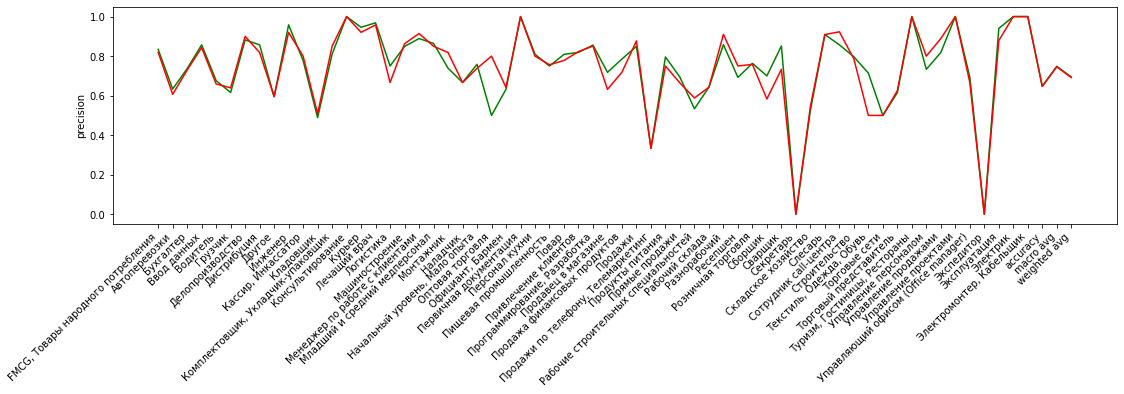

In [138]:
sns.lineplot(x=report.index, y=report['precision'], color='green')
pyplot.xticks(rotation=45, ha="right");
sns.lineplot(x=report_lem.index, y=report_lem['precision'], color='red')

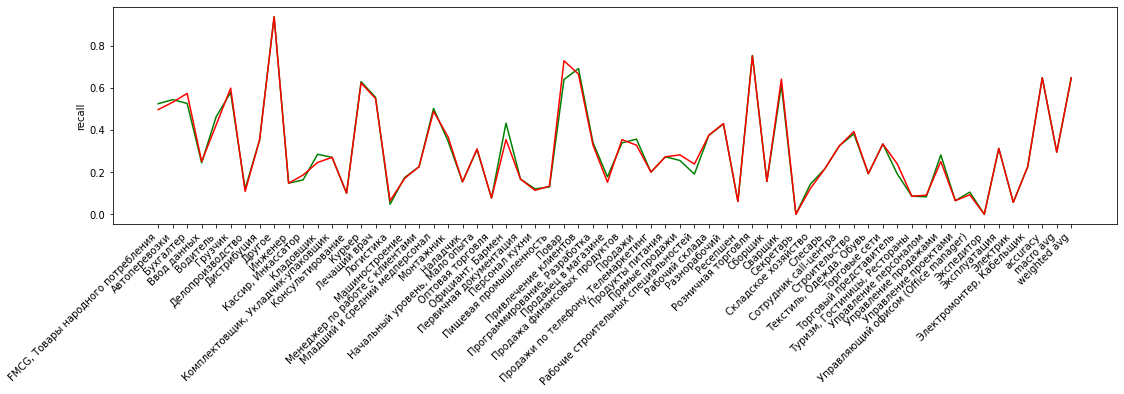

In [139]:
sns.lineplot(x=report.index, y=report['recall'], color='green')
pyplot.xticks(rotation=45, ha="right");
sns.lineplot(x=report_lem.index, y=report_lem['recall'], color='red')

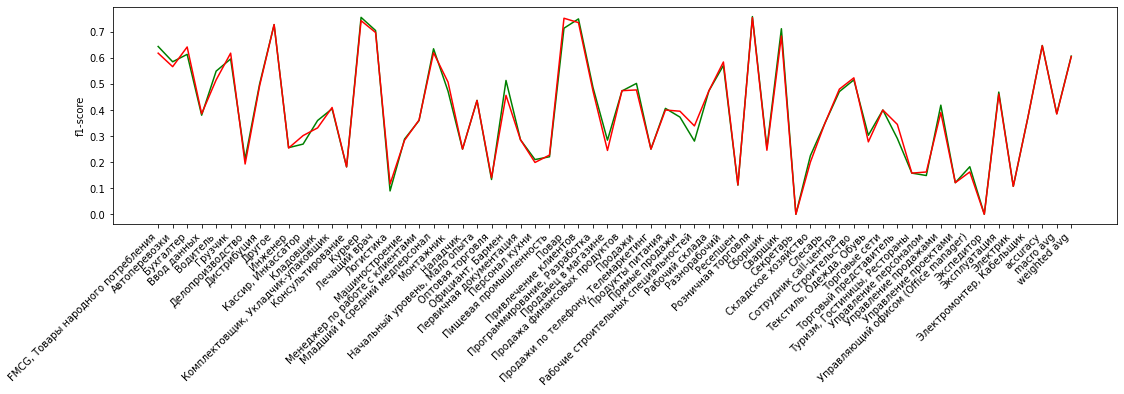

In [140]:
sns.lineplot(x=report.index, y=report['f1-score'], color='green')
pyplot.xticks(rotation=45, ha="right");
sns.lineplot(x=report_lem.index, y=report_lem['f1-score'], color='red')

# prof_area

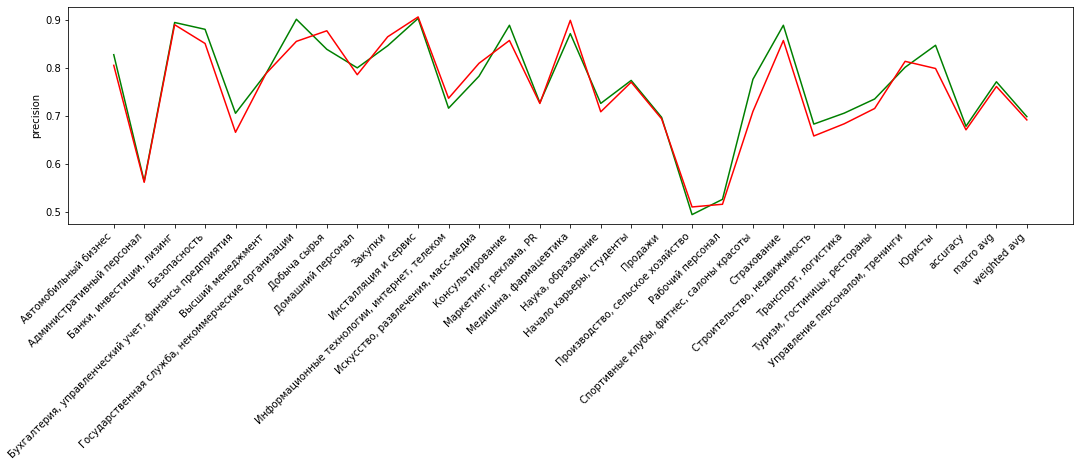

In [176]:
sns.lineplot(x=report.index, y=report['precision'], color='green')
pyplot.xticks(rotation=45, ha="right");
sns.lineplot(x=report_raw.index, y=report_raw['precision'], color='red')

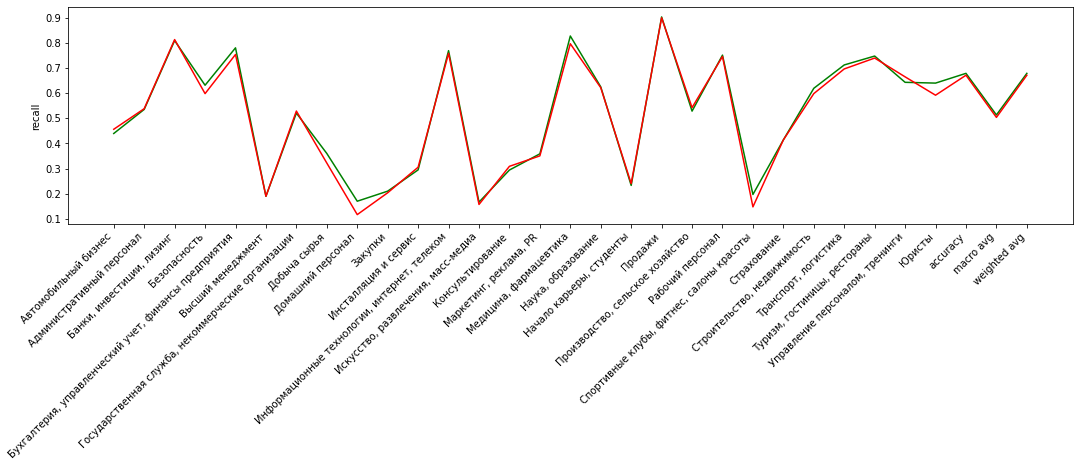

In [177]:
sns.lineplot(x=report.index, y=report['recall'], color='green')
pyplot.xticks(rotation=45, ha="right");
sns.lineplot(x=report_raw.index, y=report_raw['recall'], color='red')

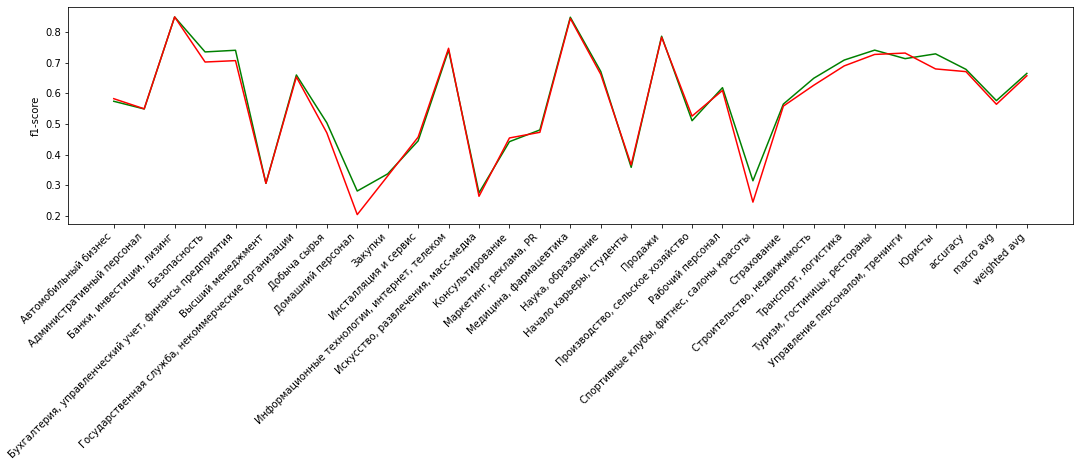

In [178]:
sns.lineplot(x=report.index, y=report['f1-score'], color='green')
pyplot.xticks(rotation=45, ha="right");
sns.lineplot(x=report_raw.index, y=report_raw['f1-score'], color='red')